In [1]:
import sys
print(sys.version)

3.5.2 (default, Nov 23 2017, 16:37:01) 
[GCC 5.4.0 20160609]


In [2]:
# This is a helper class to track computing time
import time
class Reporter(object):
    def __init__(self):
        self.ctime = time.time()
        self.stime = self.ctime
        self.ltime = self.ctime
        pass
    def report(self, string):
        self.ctime = time.time()
        print("dt: %.2f, total: %.2f -- %s" % (self.ctime - self.ltime, self.ctime - self.stime, string))
        self.ltime = self.ctime

In [3]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
import pymc3 as pm
import numpy as np
import theano as th

# list of available distributions
# https://docs.pymc.io/api/distributions.html

In [4]:
# Start generating simulated data
# The TFs: Number of TF and activation state of each
NX = 7
Xgt = dict(zip(list(range(NX)), [0]*NX))

# the target genes: Number of target genes and state of each
NY = 70
Y = dict(zip(list(range(NX,NX+NY)), [0]*NY))

In [5]:
# generate a random set of interations between TFs and genes
edges = {}
for trg in Y.keys():
    # randomize the number of TFs for this gene
    num_edges = np.random.binomial(3, 0.5)
    
    # pick random TFs
    for src in np.random.choice(list(Xgt.keys()), size=num_edges, replace=False):
        # here an edge can be valid (1) or not valid (0)
        edges[(src, trg)] = np.random.choice([-1, 1])
    

In [6]:
# A small visualization of the interactions between TFs and target genes
G = nx.DiGraph()
G.add_nodes_from(Xgt.keys())
G.add_nodes_from(Y.keys())
G.add_edges_from(edges.keys())

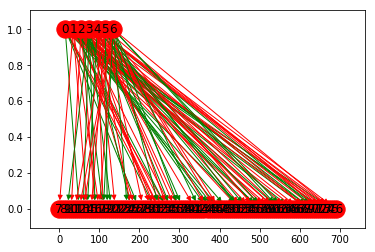

In [7]:
# a dictionary for mapping colors to signs
cdict = {-1: 'g',
         0: 'b',
         1: 'r'}

labels = {}
for node in G.nodes():
    G.nodes[node]['label'] = node
    labels[node] = node

for u,v in G.edges():
    G[u][v]['color'] = cdict[edges[(u,v)]]
colors = [G[u][v]['color'] for u,v in G.edges()]
    
pos = {}
for i, node in enumerate(Xgt.keys()):
    pos[node] = [i*20+15, 1]
for i, node in enumerate(Y.keys()):
    pos[node] = [i*10, 0]

nx.draw_networkx_nodes(G, pos=pos, nodelist=Xgt.keys())
nx.draw_networkx_nodes(G, pos=pos, nodelist=Y.keys())
nx.draw_networkx_edges(G, pos=pos, edge_color=colors)
nx.draw_networkx_labels(G, pos=pos, labels=labels, font_size=12)
plt.show()

<BarContainer object of 10 artists>

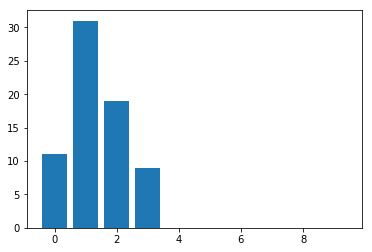

In [8]:
#list(G.predecessors(27))
h = nx.degree_histogram(G)[:10]
plt.bar(range(len(h)), h)

In [9]:
# randomize current activation state for TFs
# and then determine the state of targeted genes
for src in Xgt.keys():
    # either active (1) or inactive (0)
    Xgt[src] = np.random.choice([0, 1])
    if Xgt[src] != 0:
        for trg in Y.keys():
            edge = src, trg
            if edge in edges.keys():
                if edges[edge] < 0 and Xgt[src] > 0:
                    # if TF is inhibitor, make sure the response is definitive
                    Y[trg] += edges[edge]*Xgt[src]*10000
                else:
                    Y[trg] += edges[edge]*Xgt[src]

In [10]:
Xgt

{0: 1, 1: 0, 2: 0, 3: 1, 4: 0, 5: 0, 6: 0}

In [11]:
#Y

In [12]:
# get only the signs for gene activation states
for trg in Y.keys():
    Y[trg] = np.sign(Y[trg])

In [13]:
#Y

In [14]:
# this is the possible associations data
rels = pd.DataFrame(list(edges.keys()), columns=['srcuid', 'trguid'])
rels = rels.assign(val=list(edges.values()))

In [15]:
# extract a dataframe that only contains relevant interactions
rels2 = rels[rels['trguid'].isin(Y.keys())]

# create several dictionaries for mapping uids to a range starting from zero
# this is for better performance by making a single function call
# to create the distributions in pymc3
xs = rels2['srcuid'].unique()
ys = Y.keys()
Dx = dict(zip(xs, range(len(xs))))
Dy = dict(zip(ys, range(len(ys))))

# this is the inverse of the dictionary
# it simply goes in the reverse direction
ADx = {}
for src, i in Dx.items():
    ADx[i] = src

Ds = {}
ADs = {}
for i, (index, row) in enumerate(rels2.iterrows()):
    src = row['srcuid']
    trg = row['trguid']
    Ds[(src, trg)] = i
    ADs[i] = src, trg

In [16]:
model = pm.Model()
reporter = Reporter()

with model:
    p = {}

    reporter.report('Start')

    # Unobserved states for TFs
    X = pm.Beta('X', shape=(len(Dx),), alpha=0.4, beta=0.4)
    reporter.report('Created TF state variables')

    # Unobserved signs of edges (positive or negative)
    S = pm.Beta('S', shape=(len(rels2),), alpha=0.3, beta=0.3)
    reporter.report('Created S sign variables')
    
    # Wire up the logic
    T = {}
    for trg, j in Dy.items():
        T[j] = {}
        
    for (src, trg), k in Ds.items():
        i = Dx[src]
        j = Dy[trg]
        T[j][i] = 1 - X[i] * S[k] # X ^ S

    reporter.report('Completed gates for Ts')
    
    U = {}
    for trg, j in Dy.items():
        U[j] = {}
        
    for (src, trg), k in Ds.items():
        i = Dx[src]
        j = Dy[trg]
        U[j][i] = 1 - X[i] * (1 - S[k]) # X ^ S

    reporter.report('Completed gates for Us')
    
    # OR gate for all TFs potentially activating genes
    t = {}
    for trg, j in Dy.items():
        t[j] = 1.
        for i in T[j].keys():
            t[j] *= T[j][i]
        t[j] = 1 - t[j]
    
    # OR gate for all TFs potentially repressing genes
    u = {}
    for trg, j in Dy.items():
        u[j] = 1.
        for i in U[j].keys():
            u[j] *= U[j][i]
        u[j] = 1 - u[j]
    
    ## There is no AND gate in this part of this model
    #p = {}
    #for trg, j in Dy.items():
    #    p[j] = t[j] * (1 - u[j])
    #reporter.report('Completed gates for Ps')
    
    # need to convert dictionaries into lists
    tt, uu = [], []
    for trg, j in Dy.items():
        tt.append(t[j])
        uu.append(u[j])

    # in this model we are going to use a Multinomial distribution
    # pymc3 is picky with the p argument, it requires a tensor object
    tt = th.tensor.cast(tt, 'float32')
    uu = th.tensor.cast(uu, 'float32')
    # the Y = -1 value is given by the inhibitors brach of the circuit
    p0 = uu/2
    # the Y = 1 value is given by the activators brach of the circuit
    p2 = tt/2
    # the Y = 0 value is given by the complement
    p1 = 1 - p0 - p2
    # put together the matrix for p
    pp = th.tensor.stack([p0, p1, p2], axis=1)
    
    # setup the observations in the format required by the multinomial likelihood
    YY = []
    for trg, j in Dy.items():
        tmp = [0, 0, 0]
        tmp[1 + Y[trg]] = 1
        YY.append(tmp)
    
    reporter.report('Rearranged Ps and Ys for likelihood function')
    
    # the likelihood
    D = pm.Multinomial('D', n=1, p=pp, observed=YY)
    reporter.report('Set observed distributions')
    

dt: 0.00, total: 0.00 -- Start
dt: 2.33, total: 2.33 -- Created TF state variables
dt: 0.33, total: 2.66 -- Created S sign variables
dt: 0.23, total: 2.89 -- Completed gates for Ts
dt: 0.29, total: 3.18 -- Completed gates for Us
dt: 0.29, total: 3.47 -- Rearranged Ps and Ys for likelihood function
dt: 0.50, total: 3.97 -- Set observed distributions


In [17]:
reporter = Reporter()
reporter.report('Start')
with model:
    reporter.report('Model Initiated')
    # draw posterior samples
    trace = pm.sample(tune=1000, draws=500, step=None, chains=3, njobs=3)
    reporter.report('Finished Sampling')


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


dt: 0.00, total: 0.00 -- Start
dt: 0.00, total: 0.00 -- Model Initiated


Multiprocess sampling (3 chains in 3 jobs)
NUTS: [S, X]
Sampling 3 chains: 100%|██████████| 4500/4500 [00:26<00:00, 167.72draws/s]
There were 154 divergences after tuning. Increase `target_accept` or reparameterize.
There were 191 divergences after tuning. Increase `target_accept` or reparameterize.
There were 153 divergences after tuning. Increase `target_accept` or reparameterize.


dt: 60.03, total: 60.03 -- Finished Sampling


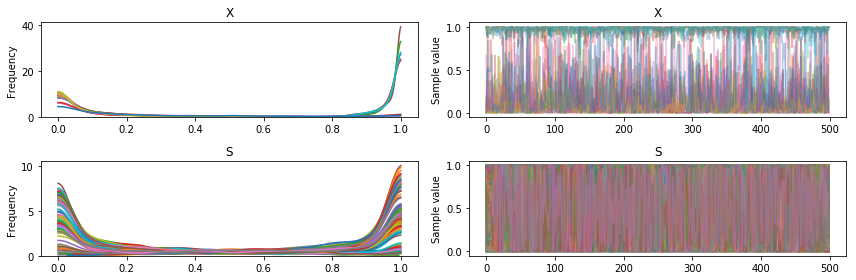

In [18]:
plots = pm.traceplot(trace)

In [19]:
result = pm.summary(trace)

In [20]:
ADx = {}
for src, i in Dx.items():
    ADx[i] = src

In [21]:
Xres = result.loc[['X__%d'%i for i in range(len(Dx))]]
Xres = Xres.assign(srcuid=[ADx[i] for i in range(len(Dx))])
Xres = Xres.assign(ground_truth=[Xgt[src] for src in Xres['srcuid']])
Xres = Xres.assign(prediction=Xres['mean'].round())
Xres = Xres.assign(correctness=Xres['ground_truth']==Xres['prediction'])
Xres = Xres.drop(columns=['mc_error', 'hpd_2.5', 'hpd_97.5', 'n_eff', 'Rhat'])

In [22]:
Xres

,mean,sd,srcuid,ground_truth,prediction,correctness
X__0,0.107281,0.154107,1,0,0.0,True
X__1,0.089827,0.125457,4,0,0.0,True
X__2,0.109129,0.150404,2,0,0.0,True
X__3,0.964402,0.051374,0,1,1.0,True
X__4,0.093013,0.135117,5,0,0.0,True
X__5,0.969292,0.045246,3,1,1.0,True
X__6,0.264397,0.304451,6,0,0.0,True


In [23]:
Xres['correctness'].value_counts(normalize=True)

True    1.0
Name: correctness, dtype: float64

In [24]:
# filter S variables
Sres = result.loc[['S__%d'%i for i in range(len(Ds))]]
# remove unused columns
Sres = Sres.drop(columns=['mc_error', 'hpd_2.5', 'hpd_97.5', 'n_eff', 'Rhat'])
# associate variable S with its corresponding edge
Sres = Sres.assign(edge=[ADs[i] for i in range(len(Ds))])
# column for srcuid
Sres = Sres.assign(srcuid=[src for src, trg in Sres['edge']])
# column for trguid
Sres = Sres.assign(trguid=[trg for src, trg in Sres['edge']])
# specify whether TF was active in this experiment
# only active TFs provide useful information in the inference proccess
Sres = Sres.assign(srcactive=[Xgt[src] for src in Sres['srcuid']])
# the ground truth. Here S represents the sign of regulation
Sres = Sres.assign(ground_truth=[edges[edge] for edge in Sres['edge']])
# process prediction values
conditions = [Sres['mean'] < 0.35, Sres['mean'] > 0.65]
choices = [-1, 1]
Sres = Sres.assign(prediction=np.select(conditions, choices, default=0))
# filter out where predictions where not made
Sres = Sres[Sres['prediction']!=0]
# compare ground truth with predicted value
Sres = Sres.assign(correctness=Sres['ground_truth']==Sres['prediction'])
# show only edges from active TFs. 
Sres = Sres[Sres['srcactive']>0]


In [25]:
Sres.sort_values(by=['edge'])

,mean,sd,edge,srcuid,trguid,srcactive,ground_truth,prediction,correctness
S__27,0.254360,0.300964,"(0, 12)",0,12,1,-1,-1,True
S__46,0.184513,0.233844,"(0, 27)",0,27,1,-1,-1,True
S__93,0.208603,0.264969,"(0, 31)",0,31,1,-1,-1,True
S__12,0.716517,0.339069,"(0, 32)",0,32,1,1,1,True
S__33,0.747013,0.308441,"(0, 34)",0,34,1,1,1,True
S__85,0.737474,0.304770,"(0, 57)",0,57,1,1,1,True
S__45,0.826377,0.230932,"(0, 60)",0,60,1,1,1,True
S__11,0.185507,0.232612,"(0, 65)",0,65,1,-1,-1,True
S__71,0.807421,0.246332,"(0, 66)",0,66,1,1,1,True
S__17,0.214474,0.281596,"(0, 70)",0,70,1,-1,-1,True


In [26]:
Sacc = Sres['correctness'].value_counts(normalize=True)[True]
print("Edge sign prediction accuracy:", Sacc)

Edge sign prediction accuracy: 1.0


In [27]:
len(Sres)

22